# Scale effects

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [90]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator, function_eq, subs_simpler
from scipy.optimize import least_squares
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.prime_system import PrimeSystem, df_prime
import statsmodels.api as sm
import zigzag
import logging
log = logging.getLogger(__name__)
import paper
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [31]:
table_scaling = pd.DataFrame()
denominators = df_prime.loc['denominator']
table_scaling['SI unit'] = df_prime.loc['SI unit'].apply(lambda x:"$"+x.replace('*',' \cdot ')+"$")
table_scaling['Prime system'] = denominators.apply(lambda x:f"${sp.latex(x)}$")
table_scaling.drop(index='-', inplace=True)

In [32]:
lambda_ = sp.symbols(r'lambda') 
scaled = denominators.apply(lambda x:x.subs([(L,L*lambda_),(U,U*sp.sqrt(lambda_),)]))
scale_factors = scaled/denominators
table_scaling['Froude scaling'] = scale_factors.apply(lambda x:f"${sp.latex(x)}$")

In [33]:
table_scaling.index.name="Physical quantity"
table = table_scaling.reset_index()
table["Physical quantity"] = table["Physical quantity"].apply(lambda x:x.replace('_',' '))
table.sort_values(by="Physical quantity")

,Physical quantity,SI unit,Prime system,Froude scaling
8,angle,$rad$,$1$,$1$
12,angular acceleration,$rad/s^2$,$\frac{U^{2}}{L^{2}}$,$\frac{1}{\lambda}$
10,angular velocity,$rad/s$,$\frac{U}{L}$,$\frac{1}{\sqrt{\lambda}}$
7,area,$m^2$,$L^{2}$,$\lambda^{2}$
3,density,$kg/m^3$,$\frac{\rho}{2}$,$1$
13,force,$N$,$\frac{L^{2} U^{2} \rho}{2}$,$\lambda^{3}$
6,frequency,$1/s$,$\frac{U}{L}$,$\frac{1}{\sqrt{\lambda}}$
4,inertia moment,$kg \cdot m^2$,$\frac{L^{5} \rho}{2}$,$\lambda^{5}$
0,length,$m$,$L$,$\lambda$
11,linear acceleration,$m/s^2$,$\frac{U^{2}}{L}$,$1$


In [88]:
table.to_csv(paper.file_path_with_nb_ref("scalings.csv", directory='tables'), index=False)

In [35]:
%reload_kedro
ship='7m'
model_loaders = catalog.load(f"{ship}.models")
time_series = catalog.load(f"{ship}.tests")
#time_series = catalog.load(f"{ship}.tests_ek_smooth")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
ship_data = catalog.load(f"{ship}.ship_data")
units = catalog.load(f"{ship}.units")

[07/19/23 10:29:54] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=158606;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=258407;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/19/23 10:30:05] INFO     Kedro project phd                                                      ]8;id=894518;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=396443;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=731691;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=220907;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=853577;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=772755;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=651009;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=33953;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=975356;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=254739;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=155508;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=127096;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=922603;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=915055;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=654382;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=918409;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [36]:
%reload_kedro
ship='wPCC'
time_series_wPCC = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
time_series_meta_data_wPCC = catalog.load(f"{ ship }.time_series_meta_data")
ship_data_wPCC = catalog.load(f"{ship}.ship_data")
model_loaders_MDL = catalog.load(f"{ship}.models")

                    INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=132485;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=501477;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/19/23 10:30:15] INFO     Kedro project phd                                                      ]8;id=196056;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=539220;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=471676;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=804697;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=367953;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=849718;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=699242;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=869247;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=986718;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=753999;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=636393;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=501360;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=694962;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=644720;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [37]:
def preprocess(data):
    data['-delta_deg'] = -np.rad2deg(data['delta'])
    psi0 = data.iloc[0]['psi'].copy()
    data['psi']-=psi0
    data['x0']-=data['x0'].iloc[0]
    data['y0']-=data['y0'].iloc[0]
    x0 = data['x0'].copy()
    y0 = data['y0'].copy()
    data['x0'] = x0*np.cos(psi0) + y0*np.sin(psi0)
    data['y0'] = -x0*np.sin(psi0) + y0*np.cos(psi0)
    data['psi_deg'] = np.rad2deg(smallest_signed_angle(data['psi']))

## Field study data

In [76]:
field_data = {}

id=6
data = time_series[str(id)]().loc[0:40].copy()
preprocess(data)
field_data[f"Field test {id}"]=data

id=8
data = time_series[str(id)]().loc[0:40].copy()
preprocess(data)
field_data[f"Field test {id}"]=data



## Model test data

In [77]:
id = 22764
data_wPCC = time_series_wPCC[f'wpcc.updated.{id}.ek_smooth']()
i = np.argmax(np.abs(np.gradient(data_wPCC['delta'],data_wPCC.index)) > np.deg2rad(2.32)*np.sqrt(ship_data_wPCC['scale_factor']))
data_wPCC=data_wPCC.iloc[i:].copy()
data_wPCC['x0']-=data_wPCC.iloc[0]['x0']
data_wPCC['y0']-=data_wPCC.iloc[0]['y0']
data_wPCC.index-=data_wPCC.index[0]

data_wPCC['V'] = data_wPCC['U'] = np.sqrt(data_wPCC['u']**2 + data_wPCC['v']**2)
data_wPCC['-delta_deg'] = -np.rad2deg(data_wPCC['delta'])
data_wPCC['psi']-=data_wPCC.iloc[0]['psi']
data_wPCC['psi_deg'] = np.rad2deg(data_wPCC['psi'])
data_wPCC["rev"] = data_wPCC[["Prop/SB/Rpm", "Prop/PS/Rpm"]].mean(axis=1)

In [78]:
model_MDL = model_loaders_MDL['vmm_martins_simple_thrust.MDL_inverse_dynamics']()
model = model_loaders['vmm_martins_simple_thrust.MDL_inverse_dynamics']()

## Scaling model test data to 7m

In [79]:
scaling=model_MDL.ship_parameters['scale_factor']/model.ship_parameters['scale_factor']
scaling

1.3733333333333335

In [80]:
data_wPCC_prime = model_MDL.prime_system.prime(data_wPCC[model_MDL.states_str + model_MDL.control_keys + ['V']], U=data_wPCC['V'])
data_wPCC_7m = model.prime_system.unprime(data_wPCC_prime, U=data_wPCC['V']*np.sqrt(scaling))
data_wPCC_7m.index*=np.sqrt(scaling)

In [81]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

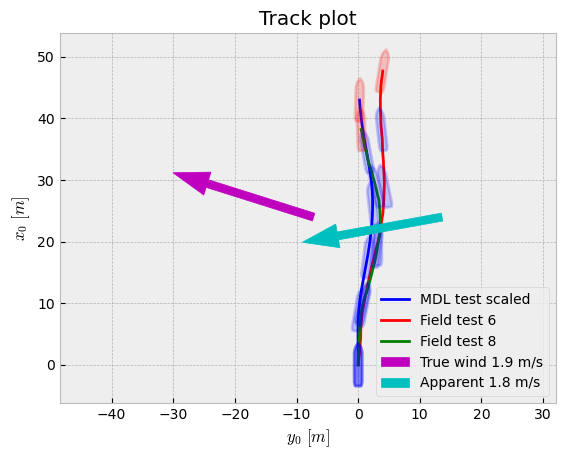

In [85]:
dataframes = {
    'MDL test scaled':data_wPCC_7m.loc[0:data.index[-1]],
}
dataframes.update(field_data)
track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'])

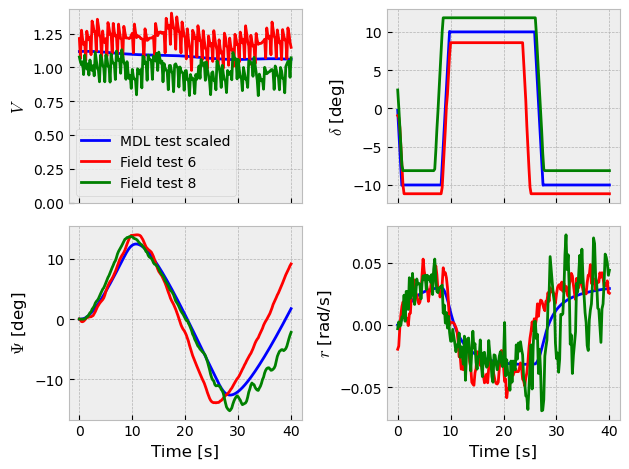

In [89]:
fig = plot(dataframes, keys=['psi','V','r','delta'], units=units, symbols=symbols_dict);
fig.savefig(paper.file_path_with_nb_ref("MDL_test_scaled.pdf"))

<Axes: >

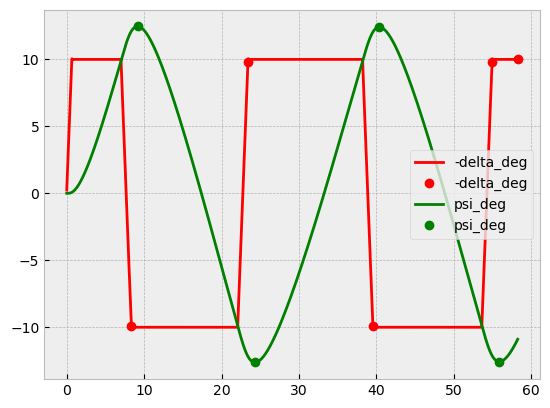

In [146]:
corners = zigzag._get_corners(angle=np.deg2rad(10), df=data_wPCC)
maximums = zigzag._get_maximums(df=data_wPCC, corners=corners)

fig,ax=plt.subplots()
data_wPCC.plot(y='-delta_deg', style='r-', ax=ax)
corners.plot(y='-delta_deg', style='ro', ax=ax)

data_wPCC.plot(y='psi_deg', style='g-', ax=ax)
maximums.plot(y='psi_deg', style='go', ax=ax)

In [115]:
zigzag.get_overshoots(angle=np.deg2rad(10), df=data_wPCC_7m)

10.722821    2.468470
28.488720    2.618598
47.297604    2.407741
65.473665    2.564913
Name: psi, dtype: float64

<Axes: xlabel='time(us)'>

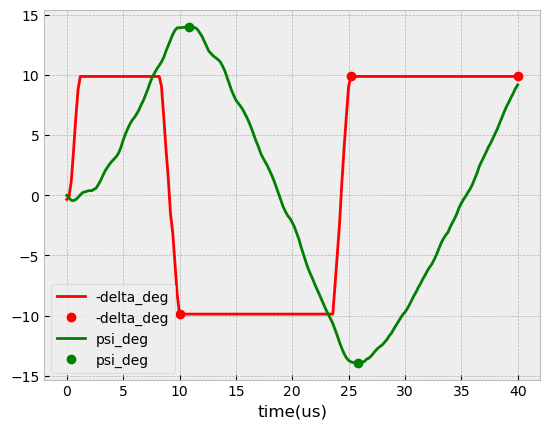

In [144]:
id = "Field test 6"

df = field_data[id].copy()
df['psi_deg'] = np.rad2deg(df['psi'])
df['delta']-=(df['delta'].max() + df['delta'].min())/2
df['-delta_deg']=-np.rad2deg(df['delta'])

corners = zigzag._get_corners(angle=np.deg2rad(10), df=df)
maximums = zigzag._get_maximums(df=df, corners=corners)

fig,ax=plt.subplots()
df.plot(y='-delta_deg', style='r-', ax=ax)
corners.plot(y='-delta_deg', style='ro', ax=ax)

field_data[id].plot(y='psi_deg', style='g-', ax=ax)
maximums.plot(y='psi_deg', style='go', ax=ax)

In [145]:
zigzag.get_overshoots(angle=np.deg2rad(10), df=df)

time(us)
10.799802    3.990788
25.799617    3.911415
Name: psi, dtype: float64

In [268]:
def load_MDL(id):
    data_wPCC = time_series_wPCC[f'wpcc.updated.{id}.ek_smooth']()
    #i = np.argmax(np.abs(np.gradient(data_wPCC['delta'],data_wPCC.index)) > np.deg2rad(2.32)*np.sqrt(ship_data_wPCC['scale_factor']))
    #data_wPCC=data_wPCC.iloc[i:].copy()
    data_wPCC['x0']-=data_wPCC.iloc[0]['x0']
    data_wPCC['y0']-=data_wPCC.iloc[0]['y0']
    data_wPCC.index-=data_wPCC.index[0]
    
    data_wPCC['V'] = data_wPCC['U'] = np.sqrt(data_wPCC['u']**2 + data_wPCC['v']**2)
    
    data_wPCC['psi']-=data_wPCC.iloc[0]['psi']
    
    ## scaling:
    data_wPCC_prime = model_MDL.prime_system.prime(data_wPCC[model_MDL.states_str + model_MDL.control_keys + ['V']], U=data_wPCC['V'])
    data_wPCC_7m = model.prime_system.unprime(data_wPCC_prime, U=data_wPCC['V']*np.sqrt(scaling))
    data_wPCC_7m.index*=np.sqrt(scaling)
    
    data_wPCC_7m['psi_deg'] = np.rad2deg(data_wPCC_7m['psi'])
    data_wPCC_7m['-delta_deg'] = -np.rad2deg(data_wPCC_7m['delta'])
    
    
    return data_wPCC_7m

In [294]:
def evaluate(df,angle):
    overshoots = zigzag.get_overshoots(angle=np.deg2rad(angle), df=df)
    
    results = pd.Series(name=id)
    for i, overshoot in enumerate(overshoots.values):
        results[f"overshoot_{i+1}"] = overshoot
        
    for n in range(i-1):
        results[f"period_{n+1}"] = overshoots.index[n+1] - overshoots.index[n]
        
    results['V'] = df['V'].iloc[0:10].mean()
    
    return results
    

In [295]:
_ = []
mask = time_series_meta_data_wPCC['test_type'] == 'zigzag'
time_series_selection = time_series_meta_data_wPCC.loc[mask].copy()
time_series_selection.drop(index=[22764], inplace=True)
for id, meta_data in time_series_selection.iterrows():
    
    try:
        df = load_MDL(id)
    except:
        continue
        
    angle = meta_data['angle1']
    results = evaluate(df=df, angle=angle)   
    _.append(results)
    
evaluations_MDL = pd.DataFrame(_)
evaluations_MDL = pd.merge(left=evaluations_MDL, right=time_series_meta_data_wPCC, left_index=True, right_index=True, how='left')

In [296]:
evaluations_MDL

,overshoot_1,overshoot_2,overshoot_3,overshoot_4,period_1,period_2,V,overshoot_5,period_3,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,scale_factor,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,xm,ym,zm,description
22770,2.513903,2.446363,2.447115,2.288891,17.625274,18.000280,1.106733,NaN,NaN,40199079,5,6,2,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\0...,2020-09-24,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22769,2.535368,2.467289,-1.253929,NaN,17.695577,NaN,1.110152,NaN,NaN,40199079,5,5,2,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 10/10PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\0...,2020-09-24,zigzag,MDL,10.0,10.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag10/10
22771,7.263554,5.621849,6.071580,-3.090032,20.097969,21.586273,1.113647,4.941169,6.996203,40199079,5,1,3,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 20/20SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\0...,2020-09-24,zigzag,MDL,20.0,20.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag20/20
22773,7.435742,5.401102,6.298248,5.020544,20.402659,21.152671,1.101385,NaN,NaN,40199079,5,1,4,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 20/20PS,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\0...,2020-09-25,zigzag,MDL,20.0,20.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag20/20
22772,7.375330,5.793146,5.911041,5.270874,20.320624,21.351890,1.111596,NaN,NaN,40199079,5,2,3,M5139-02-A,M5139-02-A,167,NaN,0.96177,ZZ 20/20SB,NaN,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\005\0...,2020-09-24,zigzag,MDL,20.0,20.0,41.2,Design,-0.24432,0.438908,0.136092,NaN,0.206311,0.206311,NaN,0.331311,1.253641,NaN,NaN,0.441027,0.722775,NaN,5.014563,0.946602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-0.214,ZigZag20/20


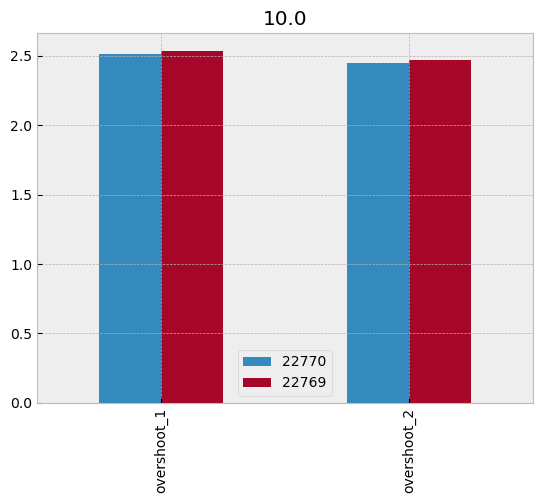

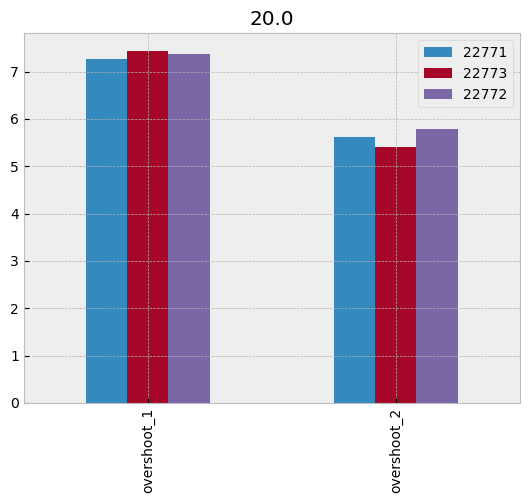

In [297]:
for angle, group in evaluations_MDL.groupby(by='angle1'):
    fig,ax=plt.subplots()
    group[['overshoot_1','overshoot_2']].transpose().plot.bar(ax=ax)
    ax.set_title(angle)

In [298]:
time_series_ek_smooth = catalog.load(f"7m.tests_ek_smooth")

[07/19/23 15:47:36] INFO     Loading data from '7m.tests_ek_smooth' (PartitionedDataSet)...     ]8;id=311571;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=243175;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [299]:
def load_field_data(id):
    data = time_series_ek_smooth[str(id)]()
    preprocess(data)
    return data

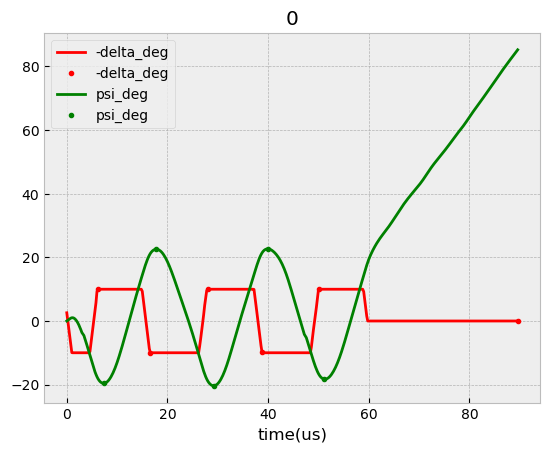

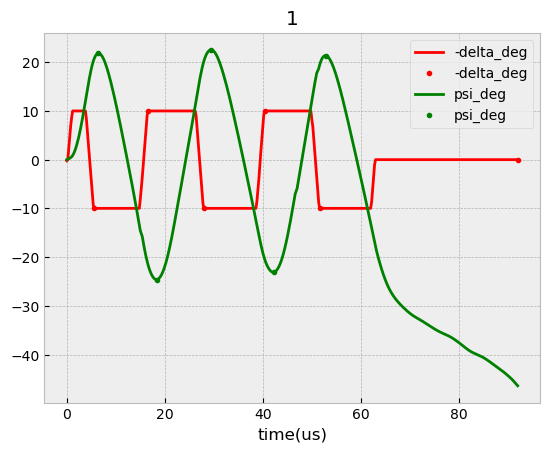

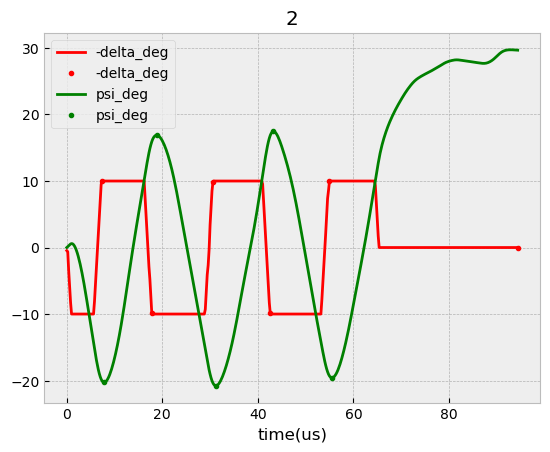

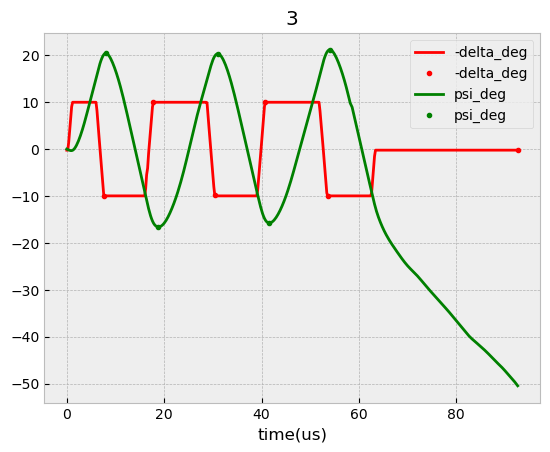

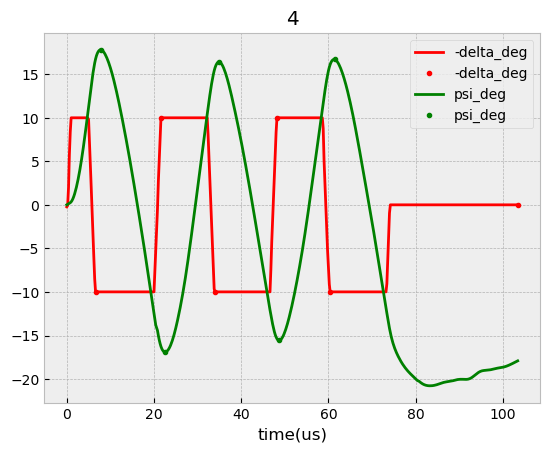

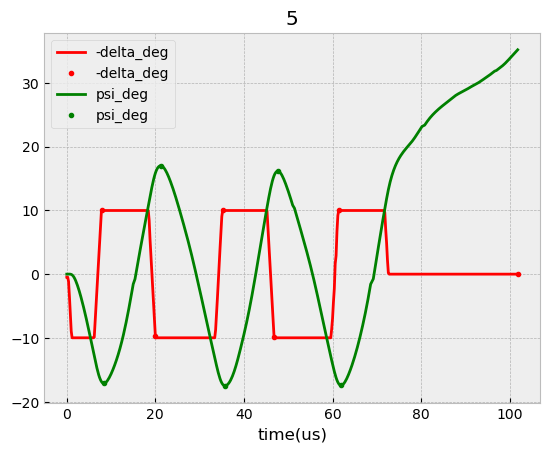

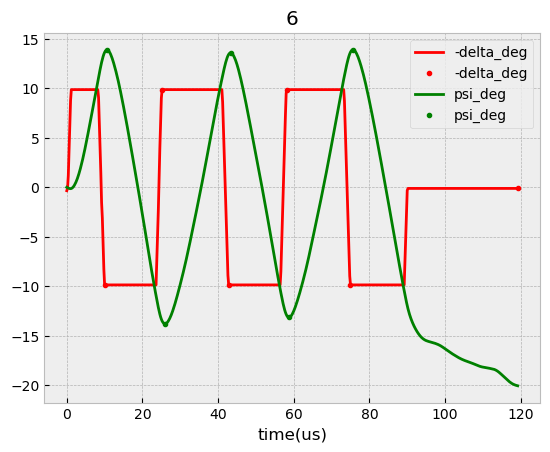

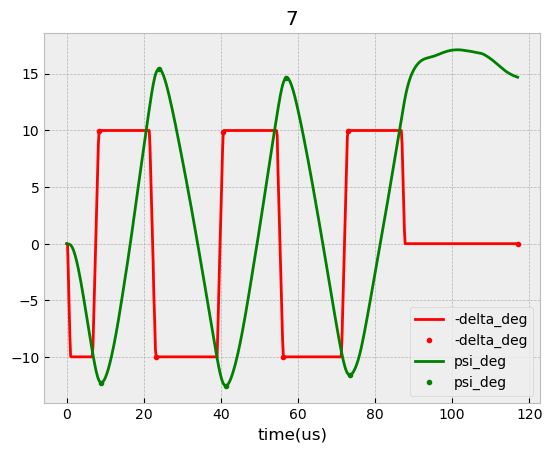

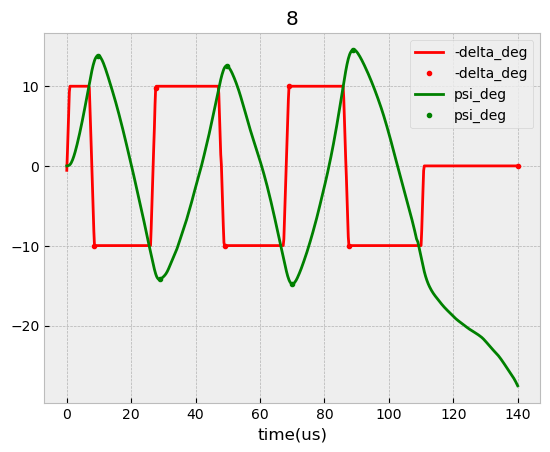

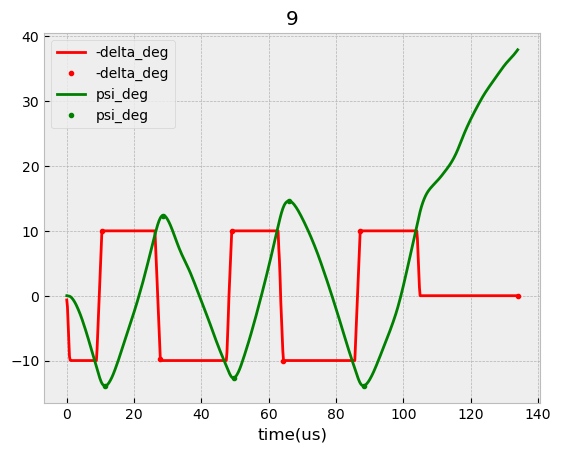

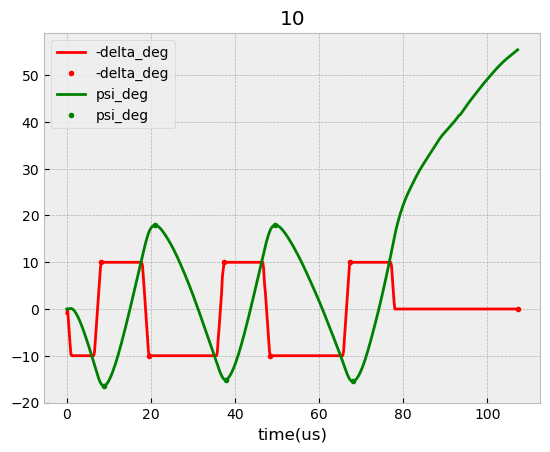

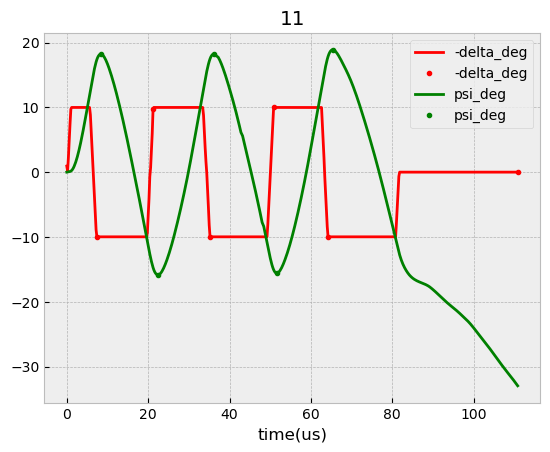

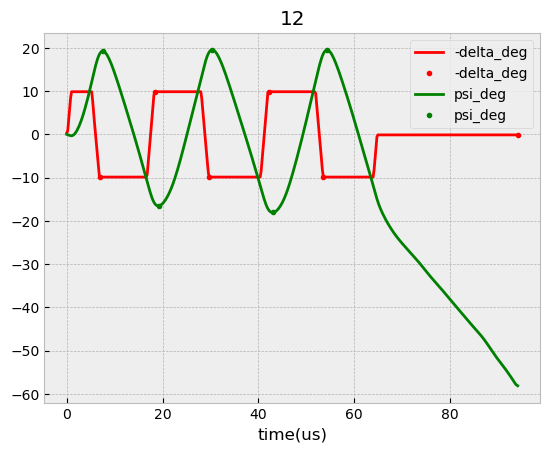

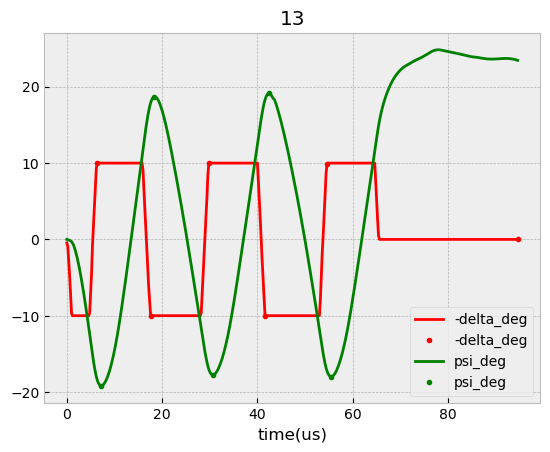

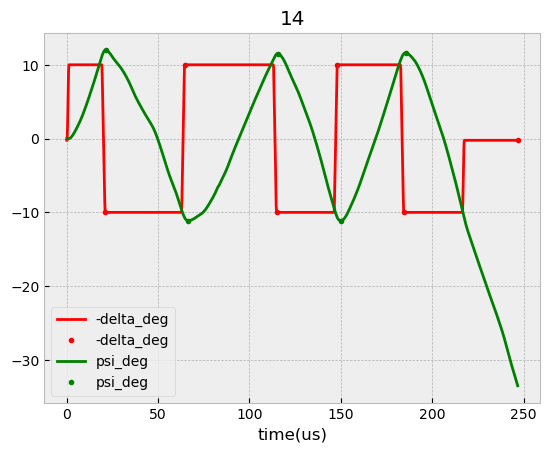

In [300]:
_ = []
mask = time_series_meta_data['type'] == 'zigzag'
time_series_selection = time_series_meta_data.loc[mask].copy()
#time_series_selection.drop(index=[22764], inplace=True)
for id, meta_data in time_series_selection.iterrows():
    
    try:
        df = load_field_data(id)
    except:
        continue
     
    df['psi_deg'] = np.rad2deg(df['psi'])
    df['delta']-=(df['delta'].max() + df['delta'].min())/2
    df['-delta_deg']=-np.rad2deg(df['delta'])
    angle = np.round(np.rad2deg((df['delta'].max() - df['delta'].min())/2)/10,0)*10
    
    corners = zigzag._get_corners(angle=np.deg2rad(angle), df=df)
    maximums = zigzag._get_maximums(df=df, corners=corners)
    
    fig,ax=plt.subplots()
    df.plot(y='-delta_deg', style='r-', ax=ax)
    corners.plot(y='-delta_deg', style='r.', ax=ax)
    
    df.plot(y='psi_deg', style='g-', ax=ax)
    maximums.plot(y='psi_deg', style='g.', ax=ax)
    ax.set_title(id)
    
    results = evaluate(df=df, angle=angle)
    results['angle1'] = angle
    _.append(results)
    
evaluations_field_data = pd.DataFrame(_)
evaluations_field_data = pd.merge(left=evaluations_field_data, right=time_series_meta_data.drop(columns=['V']), left_index=True, right_index=True, how='left')

In [301]:
evaluations_field_data.head()

,overshoot_1,overshoot_2,overshoot_3,overshoot_4,overshoot_5,period_1,period_2,period_3,V,angle1,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,psi,phi,y_GPS,x_GPS,x0,y0,u,v,r,u1d,v1d,r1d,aws,awa,U,beta,tws,twa,zigzag_test_id,inbetween_zigzags_id,date,missions,type,time_series
0,9.587504,12.549985,10.365055,12.664328,8.280836,10.399877,11.399840,10.799883,2.423870,10.0,-2.864242,-2.889786,2.234649,2.868355,2.832776,59.290854,18.324044,0.011661,-0.058411,1.826679,-3.087927,0.716626,-0.118637,1.810751,-3.054401,0.748773,100.0,-3.127585,0.009372,0.001654,-0.000898,0.017665,0.109068,-0.097567,-9.823668,-0.058420,1.811687,-2.989640,0.715064,-0.119148,1.805596,0.741702,-0.049476,-2.864242,0.011661,330.864004,1292.087658,1289.648970,330.619592,2.213642,-0.056255,0.017060,-0.003203,-0.003675,0.000107,1.808642,-0.086549,2.223786,0.025924,0.697774,0.251634,0.0,NaN,2021-04-28 10:27:01.224843,"ZigZag: start (59.29170990,18.32409477),ZigZag...",zigzag,motoring_7m_all_data
1,11.785228,14.590042,12.525805,13.086528,11.340789,11.999863,10.999863,12.799787,2.308131,10.0,2.976625,2.998750,2.168764,1.477648,1.630257,59.282847,18.322966,0.022045,-0.282939,6.409136,-0.453019,4.581796,-0.283185,5.890818,-0.491481,4.070700,100.0,-3.141585,0.008296,0.001285,-0.001100,-0.008247,0.114604,-0.222498,-9.828266,-0.258706,6.441708,-0.427223,4.606597,-0.256902,5.943986,4.109235,-0.028388,2.976625,0.022045,263.751884,400.585296,398.125072,264.628885,2.134668,0.042544,-0.008983,-0.000066,0.001760,-0.000225,6.192847,-0.257964,2.144862,-0.020765,4.359403,2.578185,1.0,NaN,2021-04-28 10:41:19.614095,"ZigZag: start (59.28369141,18.32298660),ZigZag...",zigzag,motoring_7m_all_data
2,10.249765,6.864179,10.754137,7.423222,9.554934,10.999864,12.399893,11.999772,2.165429,10.0,-0.018528,-0.013421,2.038934,3.097150,3.048385,59.286838,18.323604,0.013129,-3.125625,0.945938,3.056870,2.539891,3.102171,1.002460,3.092492,2.561186,80.0,-0.174485,0.006784,0.001729,-0.000705,0.006267,0.085932,-0.144246,-9.816204,3.088457,0.998176,3.052197,2.545398,3.016688,1.043875,2.553118,-0.053224,-0.018528,0.013129,302.978464,844.904568,847.538193,302.455591,2.017511,0.012624,0.005269,-0.000130,0.000955,-0.000106,1.021025,3.091711,2.027579,-0.005447,2.574183,3.018607,2.0,NaN,2021-04-28 10:49:38.207640,"ZigZag: start (59.28599167,18.32381248),ZigZag...",zigzag,motoring_7m_all_data
3,10.416562,6.597330,10.313376,5.754267,11.173387,10.799887,12.199836,10.599944,2.158489,10.0,-0.380535,-0.330913,2.017676,1.157022,1.210832,59.290528,18.322799,0.020048,1.498830,0.671117,-3.116795,2.194133,0.478455,0.764705,3.121852,2.015721,80.0,-0.174485,0.007668,0.002284,-0.000954,-0.008573,0.084852,-0.204163,-9.815556,0.521966,0.712779,-3.120169,2.232912,-0.111416,0.802591,2.050055,-0.021130,-0.380535,0.020048,259.700598,1256.254169,1258.484097,258.308763,1.987838,0.099047,-0.009419,-0.002492,-0.001348,-0.000729,0.757685,-0.252413,1.998064,-0.049892,2.111598,2.849044,3.0,NaN,2021-04-28 10:53:07.004897,"ZigZag: start (59.28972626,18.32312012),ZigZag...",zigzag,motoring_7m_all_data
4,7.785781,6.887490,6.385848,5.555699,6.678089,14.799815,12.399867,13.599817,1.762866,10.0,-0.236952,-0.181838,1.686831,1.948652,2.115623,59.294018,18.321129,0.017392,-2.620552,2.439717,-2.853301,3.944238,-2.685239,2.940711,-2.874346,4.453371,60.0,-0.174485,0.006392,0.001358,-0.000585,-0.002020,0.071174,-0.181219,-9.816743,-2.602669,2.447312,-2.854658,3.942908,-2.667527,2.951245,4.454529,-0.036811,-0.236952,0.017392,167.012973,1645.677685,1648.177008,165.913551,1.665611,0.092040,-0.002868,0.001272,0.001012,0.000079,2.699279,-2.635583,1.674207,-0.054830,4.199997,-3.039053,4.0,NaN,2021-04-28 10:56:51.601953,"ZigZag: start (59.29325104,18.32130241),ZigZag...",zigzag,motoring_7m_all_data


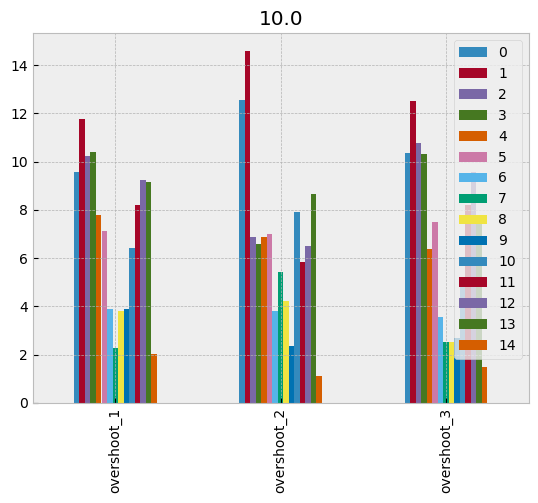

In [302]:
for angle, group in evaluations_field_data.groupby(by='angle1'):
    fig,ax=plt.subplots()
    group[['overshoot_1','overshoot_2','overshoot_3']].transpose().plot.bar(ax=ax)
    ax.set_title(angle)

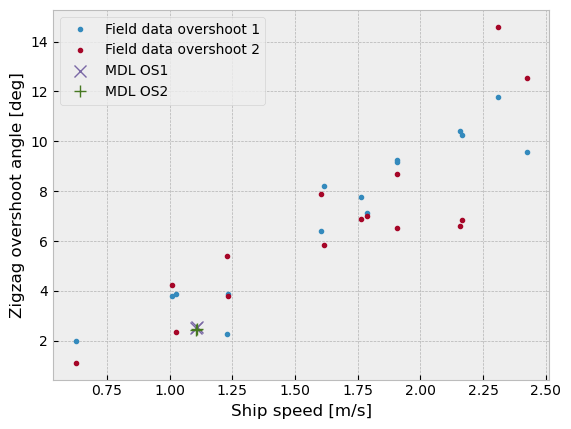

In [312]:
fig,ax=plt.subplots()
evaluations_field_data.plot(x='V', y=['overshoot_1','overshoot_2'], 
                            label=['Field data overshoot 1','Field data overshoot 2'], style='.', ax=ax)
evaluations_MDL.groupby(by='angle1').get_group(10).plot(x='V', y=['overshoot_1','overshoot_2'], 
                            label=['MDL overshoot 1','MDL overshoot 2'], style=['x','+'], ms=8, ax=ax)
ax.set_ylabel('Zigzag overshoot angle [deg]')
ax.set_xlabel('Ship speed [m/s]')
paper.save_fig(fig, file_name="overshoots.pdf")